In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score, confusion_matrix , roc_curve, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold , cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest , f_classif
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('titanic_train.csv')

data.head()

,Unnamed: 0,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
data = data.drop(['Unnamed: 0'], axis =1)

In [4]:
data.shape

(891, 12)

In [5]:
data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
data = data.drop(['Cabin'], axis =1)

In [7]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


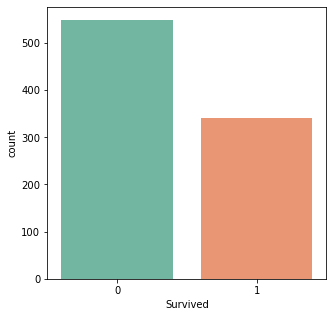

In [9]:
plt.figure(figsize=(5,5))
sns.countplot(x='Survived', data=data , palette='Set2')
plt.show()

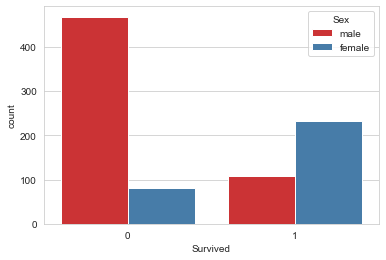

In [16]:
sns.set_style('whitegrid')
sns.countplot(x='Survived', hue='Sex', data=data , palette='Set1')
plt.show()

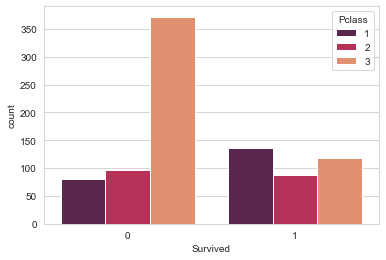

In [17]:
sns.set_style('whitegrid')
sns.countplot(x='Survived', hue='Pclass', data=data , palette='rocket')
plt.show()

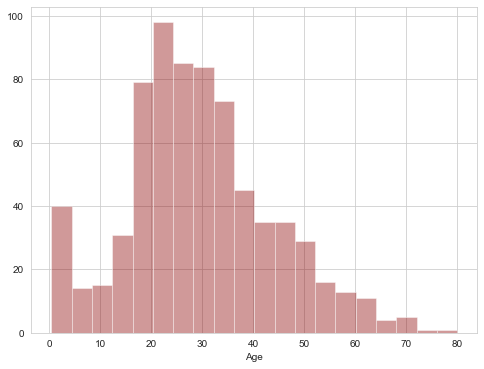

In [21]:
plt.figure(figsize=(8,6))
sns.distplot(data['Age'].dropna(),kde = False ,color ='darkred')
plt.show()

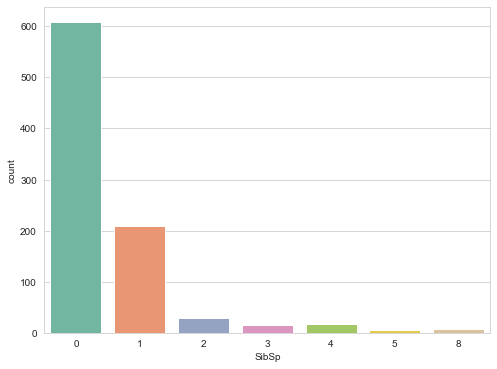

In [28]:
# Checking the total siblings / spouse size
plt.figure(figsize=(8,6))
sns.countplot(x='SibSp', data=data, palette='Set2')
plt.show()

<AxesSubplot:>

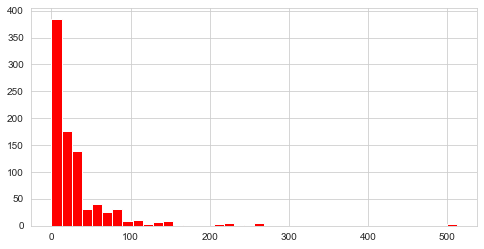

In [29]:
data['Fare'].hist(color ='red',bins=40,figsize=(8,4))

# Data Cleaning

We want to fill in missing age data instead of just dropping the missing age data rews.One way to do this is by filling in the mean age of all the passengers (imputation).However we can be smarter about this and check the average age by passanger class

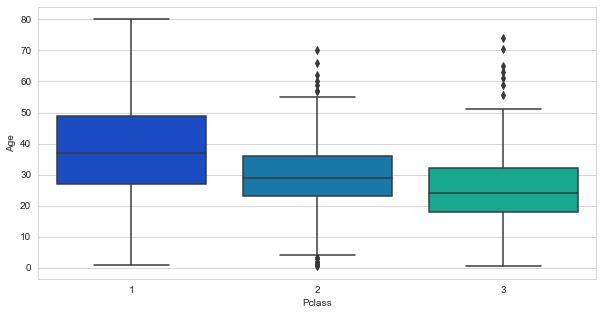

In [31]:
plt.figure(figsize=(10,5))
sns.boxplot(x='Pclass',y='Age', data = data, palette ='winter')
plt.show()

We can see the wealthier passengers in the higher classes tend to be older,which makes sence. We'll use these average age values to impute based on Pclass for age

In [32]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        
        if Pclass == 1:
            return 37
        
        elif Pclass == 2:
            return 29
        
        else:
            return 24
        
    else:
        return Age

In [34]:
data['Age'] = data[['Age','Pclass']].apply(impute_age , axis =1)

In [35]:
# Fill the Null values present in Embarked column
data['Embarked'] = data['Embarked'].fillna (data['Embarked'].mode()[0])

In [36]:
data.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [37]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.066409,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.244532,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,26.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,37.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [38]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [39]:
data.Embarked.value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [40]:
data['Embarked'] = data['Embarked'].replace({'S':1,'C':0,'Q':2})

data['Sex'] = data['Sex'].replace({'male':1,'female':0})

In [41]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,1
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,1


In [50]:
data.drop(columns=['PassengerId'],axis=1, inplace=True)
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,1
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,1
3,1,1,0,35.0,1,0,53.1000,1
4,0,3,1,35.0,0,0,8.0500,1


In [51]:
x = data.drop(columns = ['Survived']) # Features
y = data['Survived']

In [52]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [53]:
x_train,x_test,y_train,y_test = train_test_split(x_scaled,y, test_size =0.25 , random_state = 50)

In [54]:
log = LogisticRegression()

log.fit(x_train,y_train)

LogisticRegression()

In [55]:
y_pred = log.predict(x_test)

accuracy = accuracy_score(y_test,y_pred)
accuracy

0.8026905829596412

In [56]:
c_mat = confusion_matrix(y_test,y_pred)

c_mat

array([[116,  14],
       [ 30,  63]], dtype=int64)

In [57]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       130
           1       0.82      0.68      0.74        93

    accuracy                           0.80       223
   macro avg       0.81      0.78      0.79       223
weighted avg       0.80      0.80      0.80       223

